In [1]:
"""
q's scratch pad

Qualitatively replicate: 

[1] Elman, J. L. (1990). Finding structure in time. 
Cognitive Science, 14(2), 179–211. 
https://doi.org/10.1016/0364-0213(90)90002-E

[2] Saffran, J. R., Aslin, R. N., & Newport, E. L. (1996). Statistical learning by 8-month-old infants. 
Science, 274(5294), 1926–1928. 
https://doi.org/10.1126/science.274.5294.1926
"""

import os 
import time 
import warnings
import itertools
import pandas as pd 
import numpy as np
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set(style='white', context='poster', font_scale=.8, rc={"lines.linewidth": 2})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')

seed_val = 0
torch.manual_seed(seed_val)
np.random.seed(seed_val)

%matplotlib inline 
%autosave 5

device = cpu


Autosaving every 5 seconds


In [2]:
import string 
all_letters = string.ascii_lowercase

# define all vocabs
chunk_size = 4
all_vocabs = [
    all_letters[i:i + chunk_size]
    for i in range(0, len(all_letters), chunk_size) 
]
print(f'All vocabs:\n{all_vocabs}')

All vocabs:
['abcd', 'efgh', 'ijkl', 'mnop', 'qrst', 'uvwx', 'yz']


In [3]:
# gen seqs, given some vocabs
def gen_story(all_vocabs, seq_len): 
    n_vocabs = len(all_vocabs)
    seq_ids = np.random.randint(n_vocabs, size=seq_len)
    seq = [all_vocabs[i] for i in seq_ids]
    # integer representation
    seq_int = [
        [all_letters.index(letter) for letter in vocab]
        for vocab in seq
    ]
    return seq, seq_int

seq_len = 12
seq, seq_int = gen_story(all_vocabs, seq_len)
print(f'Here\'s a "story":\n{seq}')
print(f'The corresponding int representation:\n{seq_int}')

Here's a "story":
['qrst', 'uvwx', 'abcd', 'mnop', 'mnop', 'mnop', 'efgh', 'mnop', 'uvwx', 'ijkl', 'qrst', 'yz']
The corresponding int representation:
[[16, 17, 18, 19], [20, 21, 22, 23], [0, 1, 2, 3], [12, 13, 14, 15], [12, 13, 14, 15], [12, 13, 14, 15], [4, 5, 6, 7], [12, 13, 14, 15], [20, 21, 22, 23], [8, 9, 10, 11], [16, 17, 18, 19], [24, 25]]


In [4]:
# vectorize the input 
def onehot_transform(seq_int_): 
    # get the unit of representation
    n_letters = len(all_letters)
    all_letters_ohe_template = np.reshape(np.arange(n_letters),newshape=(-1,1))
    # init one hot encoder
    ohe = OneHotEncoder(n_values=n_letters, sparse=False)
    ohe.fit(all_letters_ohe_template)
    # reformat the sequence
    seq_int_ = [np.reshape(vocab, newshape=(-1,1)) for vocab in seq_int_]
    # transform to one hot 
    seq_ohe = [ohe.transform(vocab) for vocab in seq_int_]
    return seq_ohe

seq_ohe = onehot_transform(seq_int)

Text(0.5, 1.0, 'The one hot representation of "qrst"')

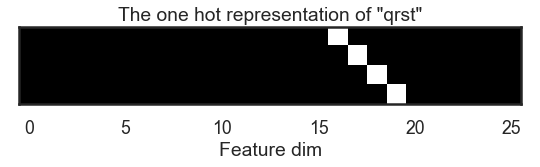

In [5]:
f, ax = plt.subplots(1,1, figsize=(9,5))

vocab_id = 0

ax.imshow(seq_ohe[vocab_id], cmap='bone')
ax.set_xlabel('Feature dim')
ax.set_yticks([])
ax.set_title(f'The one hot representation of "{seq[vocab_id]}"')

In [6]:
# generate training data
def gen_data(seq_len): 
    seq, seq_int = gen_story(all_vocabs, seq_len)
    seq_ohe = onehot_transform(seq_int)

    # to sequence to pytorch format
    seq_ohe_merged = list(itertools.chain(*seq_ohe))
    # X = np.expand_dims(seq_ohe_merged, axis=-1)
    X = np.array(seq_ohe_merged)
    X = torch.from_numpy(X).type(torch.FloatTensor)
    return X, seq

 
# how to use `gen_data`
seq_len = 25
X, seq = gen_data(seq_len)
n_time_steps = X.size()[0]
print(X.size())

torch.Size([94, 26])


In [7]:
# model params 
dim_output = dim_input = X.size()[1]
dim_hidden = 30

# training params
seq_len = 25
learning_rate = 3e-4
n_epochs = 5

# init model 
model = nn.RNN(dim_input, dim_hidden)
# model = nn.LSTM(dim_input, dim_hidden)
readout = nn.Linear(dim_hidden, dim_output)
h_0 = torch.randn(1, 1, dim_hidden)
c_0 = torch.randn(1, 1, dim_hidden)

# init optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(
    list(model.parameters())+list(readout.parameters()), 
    lr=learning_rate
)

In [9]:
# loop over epoch
losses_torch = np.zeros(n_epochs,)

for i in range(n_epochs):

    # gen data 
    X, _ = gen_data(seq_len)
    n_time_steps = X.size()[0]
    time_start = time.time()    
    
    # feed seq
    out, hidden_T = model(X.unsqueeze(0))
    xhat = readout(out)

    # compute loss
    out_sqed = torch.squeeze(xhat, dim=0)
    loss = criterion(out_sqed, X)

    losses_torch[i] += loss.item()

    # update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # print out some stuff
    time_end = time.time()
    print(f'Epoch {i} : \t loss = {losses_torch[i]}, \t time = {time_end - time_start}')
        
# print(X.unsqueeze(0).size())
# # for t, x_t in enumerate(X):
# print(x_t.view(1, 1, -1).size())        
#     print(out.size())
#     print(xhat.size())

Epoch 0 : 	 loss = 0.06436115503311157, 	 time = 0.0024797916412353516
Epoch 1 : 	 loss = 0.0631251409649849, 	 time = 0.002687215805053711
Epoch 2 : 	 loss = 0.05666011571884155, 	 time = 0.0017368793487548828
Epoch 3 : 	 loss = 0.05283668637275696, 	 time = 0.0007529258728027344
Epoch 4 : 	 loss = 0.05367518961429596, 	 time = 0.0009589195251464844


In [10]:
# # loop over epoch
# losses_torch = np.zeros(n_epochs,)

# for i in range(n_epochs):
#     # gen data 
#     X, _ = gen_data(seq_len)
#     n_time_steps = X.size()[0]
    
#     time_start = time.time()
    
#     # loop over time, for one training example
#     for t, x_t in enumerate(X):
# #         # init states
# #         if t == 0: 
# #             h_t, c_t = h_0, c_0
            
# #         # recurrent computation at time t
# #         out, (h_t, c_t) = model(
# #             x_t.view(1, 1, -1), (h_t, c_t))

#         # init states
#         if t == 0: 
#             h_t = h_0
            
#         # recurrent computation at time t
#         out, (h_t) = model(
#             x_t.view(1, 1, -1), (h_t))

#         xhat = readout(out)
        
#         # compute loss
#         out_sqed = torch.squeeze(xhat, dim=0)
#         loss = criterion(out_sqed, x_t)
#         losses_torch[i] += loss.item()
        
#         # update weights
#         optimizer.zero_grad()
#         loss.backward(retain_graph=True)
#         optimizer.step()
        
#     # print out some stuff
#     time_end = time.time()
#     if np.mod(i,5) == 0: 
#         print(f'Epoch {i} : \t loss = {losses_torch[i]}, \t time = {time_end - time_start}')

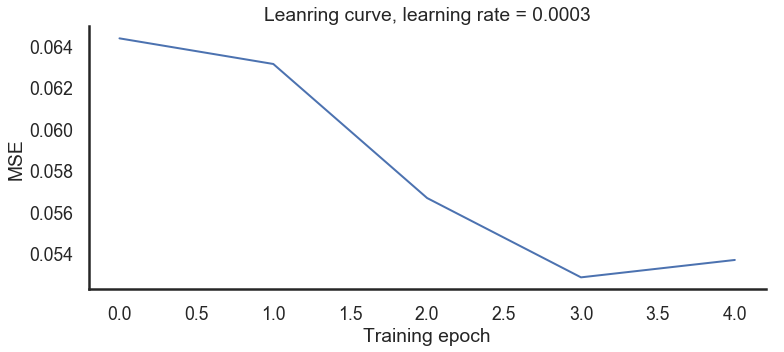

In [11]:
f, ax = plt.subplots(1,1, figsize=(11,5))
ax.plot(losses_torch)
ax.set_xlabel('Training epoch')
ax.set_ylabel('MSE')
ax.set_title(f'Leanring curve, learning rate = {learning_rate}')
sns.despine()
f.tight_layout()

In [12]:
# gen some new data 
seq_len_test = 25
X_test, seq = gen_data(seq_len_test)
n_time_steps = X_test.size()[0]

loss_test = np.zeros(n_time_steps,)

# loop over time, for one training example
for t, x_t in enumerate(X_test):
#     # init rnn states
#     if t == 0: 
#         h_t, c_t = h_0, c_0

#     # recurrent computation at time t
#     out, (h_t, c_t) = model(
#         x_t.view(1, 1, -1), (h_t, c_t))
    # init rnn states
    if t == 0: 
        h_t = h_0

    # recurrent computation at time t
    out, (h_t) = model(
        x_t.view(1, 1, -1), (h_t))
    xhat = readout(out)

    # compute loss
    out_sqed = torch.squeeze(xhat, dim=0)
    loss = criterion(out_sqed, x_t)
    loss_test[t] = loss.item()

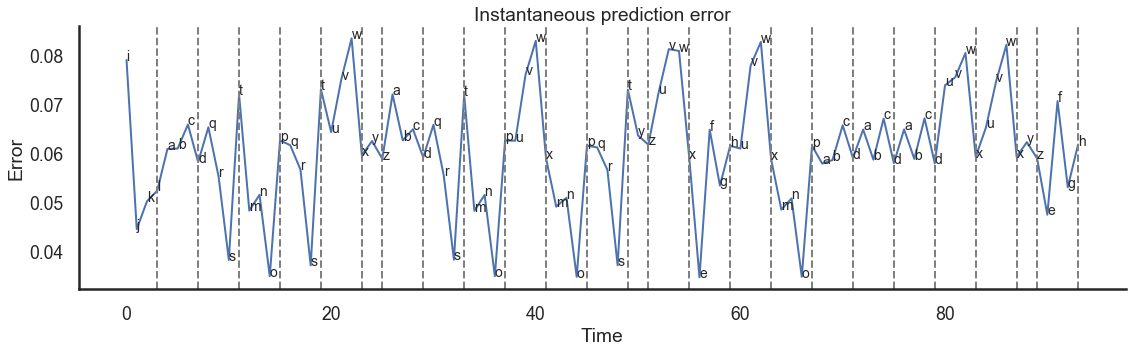

In [13]:
"""
in general, the error function over time peaks right after event(word) boundaries.
"""

word_boundaries = np.cumsum([len(vocab) for vocab in seq])-1
seq_letters = list(itertools.chain(*seq))
seq_len_test = len(seq_letters)

f,ax = plt.subplots(1,1, figsize=(16, 5))

ax.plot(np.arange(0,seq_len_test,1), loss_test)

ax.set_title('Instantaneous prediction error')
ax.set_xlabel('Time')
ax.set_ylabel('Error')

for i, letter in enumerate(seq_letters):
    ax.annotate(letter, (i, loss_test[i]), fontsize=14)

for wb in word_boundaries: 
    ax.axvline(wb, color='grey', linestyle='--')
    
sns.despine()
f.tight_layout()